## Reading IXAS spectra

*Last update: June 2021*

The International X-ray Absorption Society ([IXAS](https://xrayabsorption.org)) maintains a [data library of XAFS spectra](https://xaslib.xrayabsorption.org/elem/) for several compounds and absorption edges. In this tutorial we will be accesing the library to retrieve, process and visualize spectra in `araucaria`.

This notebook explains the the following steps:

1. Read spectra from a uniform resource locator (URL).
2. Create a collection with the spectra.
3. Plot processed spectra.

In [1]:
from araucaria.utils import get_version
print(get_version(dependencies=True))

Python version      : 3.9.4
Numpy version       : 1.20.3
Scipy version       : 1.6.3
Lmfit version       : 1.0.2
H5py version        : 3.2.1
Matplotlib version  : 3.4.2
Araucaria version   : 0.1.10


### Reading spectra directly from a URL

The IXAS data library offers a [website frontend](https://xaslib.xrayabsorption.org/elem/) to download data. However, we will be reading it directly with assistance of the [urllib](https://docs.python.org/3/library/urllib.html) module of Python.

We will be retrieving the following spectra acquired at the Se K-edge in the Advanced Photon Source synchrotron:

| Name           | ID  |
| :-             | --- |
| Se_CoSe_rt_01  | 185 |
| Se_Cu2Se_rt_01 | 187 |
| Se_CuSe_rt_01  | 189 |


For convenience we will first create a dictionary with the names and ID of spectra. This dictionary will then be used to construct a list with the URLs:

In [2]:
from os.path import join

# dictionary with names and IDs
dvals = {'names': ['Se_'+name+'_rt_01.xdi' for name in ['CoSe', 'Cu2Se', 'CuSe'] ],
         'id'   : ['185' , '187', '189']}

# constructing urls
urls   = []
static = 'https://xaslib.xrayabsorption.org/rawfile/'
for i, name in enumerate(dvals['names']):
    urls.append(static + dvals['id'][i] + '/' + name)

# printing urls
for val in urls:
    print(val)

https://xaslib.xrayabsorption.org/rawfile/185/Se_CoSe_rt_01.xdi
https://xaslib.xrayabsorption.org/rawfile/187/Se_Cu2Se_rt_01.xdi
https://xaslib.xrayabsorption.org/rawfile/189/Se_CuSe_rt_01.xdi


<div class="alert alert-info">
    
    **Note**
    
    If you want to access diferent spectra, just modify the dictionary with the names and ID of the desired spectra. Such values are available at the IXAS data library website.
</div>

Before reading the data we need to assess the file format: For this we will print the header of the last file with the [urlopen()](https://docs.python.org/3/library/urllib.request.html#urllib.request.urlopen) function of urllib: 

In [3]:
from urllib.request import urlopen

response = urlopen(val)
for i in range(30):
    print(i, response.readline().strip())

0 b'#XDI/1.1  GSE/1.0'
1 b'# Column.1: energy eV'
2 b'# Column.2: itrans'
3 b'# Column.3: i0'
4 b'# Scan.end_time: 2008-04-10 19:35:01'
5 b'# Scan.start_time: 2008-04-10 19:17:19'
6 b'# Element.symbol:  Se'
7 b'# Element.edge:  K'
8 b'# Mono.d_spacing:  3.13555'
9 b'# Mono.name: Si 111'
10 b'# Sample.temperature: room temperature'
11 b'# Sample.formula: CuSe'
12 b'# Sample.name: copper selenide, klockmannite'
13 b'# Sample.prep: powder on tape, many layers'
14 b'# Facility.Name:  APS'
15 b'# Beamline.Name:  13-BM-D'
16 b'# Beamline.xray_source:  bending magnet'
17 b'# Beamline.Storage_Ring_Current: 101.873'
18 b'# Beamline.I0: N2, 5 nA/V'
19 b'# Beamline.I1: N2, 20 nA/V'
20 b'# ScanParameters.E0: 12658.0'
21 b'# ScanParameters.Legend: Start       Stop       Step       Npts       Time   Kspace?'
22 b'# ScanParameters.Region1: -150.00    -10.000     5.0000     29.000     2.0000   0'
23 b'# ScanParameters.Region2: -10.000     30.000    0.25000     161.00     2.0000   0'
24 b'# ScanParamet

As seen from the output (line 26), the file contains columns for the energy, transmitted intensity (itrans), and reference itensity (i0), in that order.

### Create a collection with the spectra

We will use the [read_rawfile()](../../io/io_read.rst#araucaria.io.io_read.read_rawfile) function to read the files and include them in a [Collection](../../main/main_collection.rst#araucaria.main.collection.Collection):

- We first create an empty [Collection](../../main/main_collection.rst#araucaria.main.collection.Collection) to contain our group datasets.
- Contents of the remote file are accessed with the [urlopen()](https://docs.python.org/3/library/urllib.request.html#urllib.request.urlopen) funcion.
- Contents are directly passed to the [read_rawfile()](../../io/io_read.rst#araucaria.io.io_read.read_rawfile) function, and a [Group](../../main/main_group.rst#araucaria.main.group.Group) dataset is returned.
- The group is then added to the collection with the [add_group()](../../main/main_collection.rst#araucaria.main.collection.Collection.add_group) method.
- Once the collection has been populated, a summary report is requested with the [sumary()](../../main/main_collection.rst#araucaria.main.collection.Collection.summary) method.

In [4]:
from araucaria import Collection
from araucaria.io import read_rawfile

collection = Collection()
for i, url in enumerate(urls):
    content = urlopen(url)
    group   = read_rawfile(content, usecols=(0,2,1), scan='mu', ref=False, tol=1e-4)
    collection.add_group(group)

report = collection.summary()
report.show()

id  dataset             tag   mode  n  
1   Se_CoSe_rt_01.xdi   scan  mu    1  
2   Se_Cu2Se_rt_01.xdi  scan  mu    1  
3   Se_CuSe_rt_01.xdi   scan  mu    1  


<div class="alert alert-warning">
    
    **Warning**
    
    URLs or file formats in databases may change over time or between files. It is your responsibility to check the validty of the URL or the file format before reading and processing spectra.
</div>

### Plot processed spectra

Prior to plotting we need to compute the normalized spectra and the extended x-ray fine strucure (EXAFS) spetra. For this we use the [apply()](../../main/main_collection.rst#araucaria.main.collection.Collection.apply) method to process spectra in the collection.

We then use the [fig_xas_template()](../../plot_module.rst#araucaria.plot.template.fig_xas_template) function to create a `Figure` and `axes` objects with the following attributes:

- 2 pre-defined panels for XANES and EXAFS spectra.
- A dictionary to specify figure decorators (figpars).
- A dictionary to specify additional parameters of the `matplotlib` figure (fig_kws). 

Once the figure template has been created, we use a loop to populate the axes with the respective plot artists.

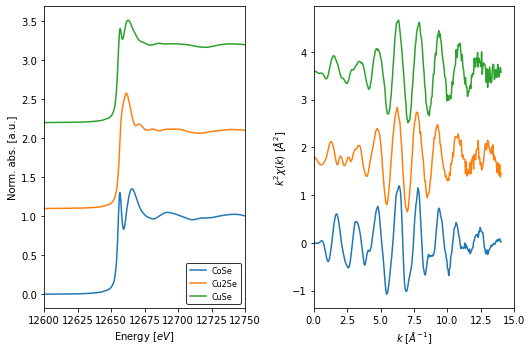

In [9]:
from araucaria.xas import pre_edge, autobk
from araucaria.plot import fig_xas_template
import matplotlib.pyplot as plt

# normalizing spectra and extracting exafs
collection.apply(pre_edge)
collection.apply(autobk)

# figure decorators
kweight = 2
offset = [1.1, 1.8]
figpars = {'e_range' : (12600, 12750),
           'k_range' : (0, 15),
           'kweight' : kweight}
fig_kws = {'figsize' : (7.5,5)}

# declaring figure and populating axes
fig, ax = fig_xas_template(panels='xe', fig_pars=figpars, **fig_kws)
names   = collection.get_names()
for i, name in enumerate(names):
    group = collection.get_group(name)
    ax[0].plot(group.energy, group.norm + i*offset[0], label=name.split('_')[1])
    ax[1].plot(group.k, group.k**kweight*group.chi + i*offset[1], label=name.split('_')[1])

ax[0].legend(loc='lower right', edgecolor='k', fontsize=8)
fig.tight_layout()
plt.show()